# Openning the data and Preparing it:

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path ="/content/drive/MyDrive/cardio_train.csv"

df = pd.read_csv(path, sep=";")
# print(df)

In [ ]:
# searching for the missing values:
row , col = np.where(df.isnull())
print(row , col) #No missing values

[] []


The grouping of numerical data into categories

In [ ]:
# 1) age
df['age'] = df['age'] / 365       #making the unit of the age a year instead of days to be more realistic

In [ ]:
# print(df['age'] , df['age'].max() , df['age'].min())  #Knowing the range of the age to split it into categories

age_bins = [29, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

# age_labels = ['29-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-65']

In [ ]:
# bin the age column using the age_bins and age_labels
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
# print(df['age'])
df = df.dropna(subset=['age'])


In [ ]:
# 2) height
# print(df['height'] , df['height'].max() , df['height'].min())
height_bins = [54,145 , 160,165 , 170 ,200, 250 ]
# height_labels = ['55-144' ,'145-159','160-164','165-169' , '170-199' , '200-250']
height_labels = [0, 1, 2, 3, 4, 5]

df['height'] = pd.cut(df['height'], bins=height_bins, labels=height_labels)
# print(df['height'].value_counts())

df = df.dropna(subset=['height'])
# df['height'] = df['height'].astype(np.int64)
# print(type(df['height'][0]))

In [ ]:
# 3) weight
# print(df['weight'] , df['weight'].max() , df['weight'].min())
weight_bins = [10 , 40 ,50 , 60 , 70 ,80 ,90 , 100 , 130 , 150 ,200 ]
weight_labels =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# weight_labels = ['10-39' ,'40-49','50-59','60-69' ,'70-79' , '80-89' ,'90-99' , '100-129' , '130-149' , '150-200']
df['weight'] = pd.cut(df['weight'], bins=weight_bins, labels=weight_labels)

df = df.dropna(subset=['weight'])

# print(df['weight'].value_counts())
# print(df['weight'])

In [ ]:
# 4) ap_hi
# Removing outliers
index_to_delete = df.index[(df['ap_hi'] >= 300) | (df['ap_hi'] <= 60)]
df = df.drop(index_to_delete)
# print(df['ap_hi'], df['ap_hi'].min() ,df['ap_hi'].max() )
ap_hi_bins = [70, 120 , 130 , 140 , 180 , 240 ]
# ap_hi_labels = ['healthy','elevated' ,'stage 1 hypertention' ,'stage 2 hypertention' , 'hypertension crisis' ]
ap_hi_labels = [0, 1, 2, 3, 4]
df['ap_hi'] = pd.cut(df['ap_hi'], bins=ap_hi_bins, labels=ap_hi_labels)
print(df['ap_hi'].value_counts())
df = df.dropna(subset=['ap_hi'])


0    40530
2     9818
1     9550
3     9525
4      329
Name: ap_hi, dtype: int64


In [ ]:
# 5) ap_lo
# Removing outliers
index_to_delete = df.index[(df['ap_lo'] >= 170) | (df['ap_lo'] <= 30)]
df = df.drop(index_to_delete)
# print(df['ap_lo'], df['ap_lo'].min() ,df['ap_lo'].max() )
ap_lo_bins = [30, 80 , 90 , 120 , 170 ]
# ap_lo_labels = ['not hyper' ,'stage 1 hypertention' ,'stage 2 hypertention' , 'hypertension crisis' ]
ap_lo_labels = [0, 1, 3, 4]

df['ap_lo'] = pd.cut(df['ap_lo'], bins=ap_lo_bins, labels=ap_lo_labels)
print(df['ap_lo'].value_counts())
df = df.dropna(subset=['ap_lo'])



0    48747
1    14872
3     5039
4       88
Name: ap_lo, dtype: int64


# My Decision Tree:

first trial..

In [ ]:
def calc_pPos_pNeg(df):
  positive_count = df['target_column'].sum()
  negative_count = len(df) - positive_count

  positive_proportion = positive_count / len(df)
  negative_proportion = negative_count / len(df)
  return positive_proportion ,negative_proportion

In [ ]:
def calc_entropy(p_pos , p_neg):
  return - p_pos * np.log2(p_pos) - p_neg * np.log2(p_neg)

In [ ]:
def calc_information_gain(p_pos_parent, p_neg_parent, child_entropies, n_examples):
    # Calculating parent entropy
    parent_entropy = calc_entropy(p_pos_parent, p_neg_parent)

    # Calculating weighted sum of child entropies
    child_entropy_sum = 0
    for child_entropy, child_n_examples in child_entropies:
        child_weight = child_n_examples / n_examples
        child_entropy_sum += child_weight * child_entropy

    # Calculating information gain
    information_gain = parent_entropy - child_entropy_sum

    return information_gain



In [ ]:
def id3(X_train, y_train, depth=0, max_depth=None):
    # Base Cases
    # Checking stopping criterion
    if (max_depth is not None and depth == max_depth) or len(X_train) == 0:
        # Return the most common class label in the dataset
        return y_train.mode()

    # Calculating the proportion of positive and negative examples in the dataset
    p_pos, p_neg = calc_pPos_pNeg(y_train)

    # Checking if all examples belong to the same class
    if p_pos == 0 or p_neg == 0:
        # Returning the class label of the examples
        return y_train.mode()

    #  Calculating the information gain for each feature
    info_gains = []
    for feature in X_train.columns:
        children = X_train.groupby(feature)
        child_entropies = children.apply(lambda df: calc_entropy(*calc_pPos_pNeg(y_train.loc[df.index])))
        info_gain = calc_information_gain(p_pos, p_neg, child_entropies, len(X_train))
        info_gains.append(info_gain)

    # Selecting the feature that maximizes the information gain
    best_feature_idx = np.argmax(info_gains)
    best_feature = X_train.columns[best_feature_idx]

    # Splitting the dataset based on the selected feature
    children = X_train.groupby(best_feature)

    # Recursively build the tree for each child node
    tree = {best_feature: {}}
    for child_value, child_df in children:
        child_y_train = y_train.loc[child_df.index]
        subtree = id3(child_df, child_y_train, depth+1, max_depth)
        tree[best_feature][child_value] = subtree

    return tree



In [ ]:
def predict(tree, example, feature=None):
    # Base Case
    if not isinstance(tree, dict):
        return tree

    # Get the current feature to split on
    if feature is None:
        feature = list(tree.keys())[0]

    # Get the feature value for the example
    feature_value = example[feature]

    # Recursively traverse the tree
    if feature_value in tree[feature]:
        subtree = tree[feature][feature_value]
        return predict(subtree, example)
    else:
        # If the feature value is not present in the tree, return the most common target value in the current node
        return list(tree[feature].values())[0]


second trial, suceed.

In [ ]:
from graphviz import Digraph

In [ ]:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _is_finished(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False

    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])
        return entropy

    def _create_split(self, X, thresh):
        left_idx = np.argwhere(X <= thresh).flatten()
        right_idx = np.argwhere(X > thresh).flatten()
        return left_idx, right_idx

    def _information_gain(self, X, y, thresh):
        parent_loss = self._entropy(y)
        left_idx, right_idx = self._create_split(X, thresh)
        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0:
            return 0

        child_loss = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
        return parent_loss - child_loss

    def _best_split(self, X, y, features):
        split = {'score':- 1, 'feat': None, 'thresh': None}

        for feat in features:
            X_feat = X[:, feat]
            thresholds = np.unique(X_feat)
            for thresh in thresholds:
                score = self._information_gain(X_feat, y, thresh)

                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['thresh'] = thresh

        return split['feat'], split['thresh']

    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # stopping criteria
        if self._is_finished(depth):
            most_common_Label = np.argmax(np.bincount(y))
            return Node(value=most_common_Label)

        # get best split
        rnd_feats = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, rnd_feats)

        # grow children recursively
        left_idx, right_idx = self._create_split(X[:, best_feat], best_thresh)
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_thresh, left_child, right_child)

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)


    def _traverse_tree_names(self, node, prefix=''):
        if node.is_leaf():
            print(prefix + 'Predict: ' + str(node.value))
            return

        print(prefix + f'X{node.feature} <= {node.threshold}')
        self._traverse_tree_names(node.left, prefix=prefix+'|   ')
        self._traverse_tree_names(node.right, prefix=prefix+'|   ')

    def print_tree(self):
        self._traverse_tree_names(self.root)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Testing My Decision Tree


Splitting the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

slc = [1,2,3,4,5,6,7,8,9,10,11]
X = df.values[:, slc]
# turn the target attribute to np.array
y= df.iloc[:,-1:].values.flatten()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

# Test the model
y_pred = clf.predict(X_test)

# Evaluate the performance
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.6902891720486414


In [ ]:
from sklearn.metrics import accuracy_score, precision_score

MyModel = DecisionTree(max_depth=5)
MyModel.fit(X_train, y_train)

y_pred = MyModel.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy =" , acc*100 ,"%")

Accuracy = 72.58392971431896 %


# Manual tested data

**Rules:**

* Information gain:
IG(S, A) = H(S) - H(S|A)

Where:

IG(S, A) is the information gain for attribute A in dataset S.
H(S) is the entropy of dataset S.
H(S|A) is the conditional entropy of dataset S given attribute A.

* Entropy:
H(S) = - Σ p(i) log2 p(i)

Where:

H(S) is the entropy of dataset S.
p(i) is the proportion of the i-th class in dataset S.

* Gain ratio:
GR(S, A) = IG(S, A) / IV(A)

Where:

GR(S, A) is the gain ratio for attribute A in dataset S.
IV(A) is the intrinsic value of attribute A, which measures the potential information generated by splitting on A.


**The Resulted Decision Tree**
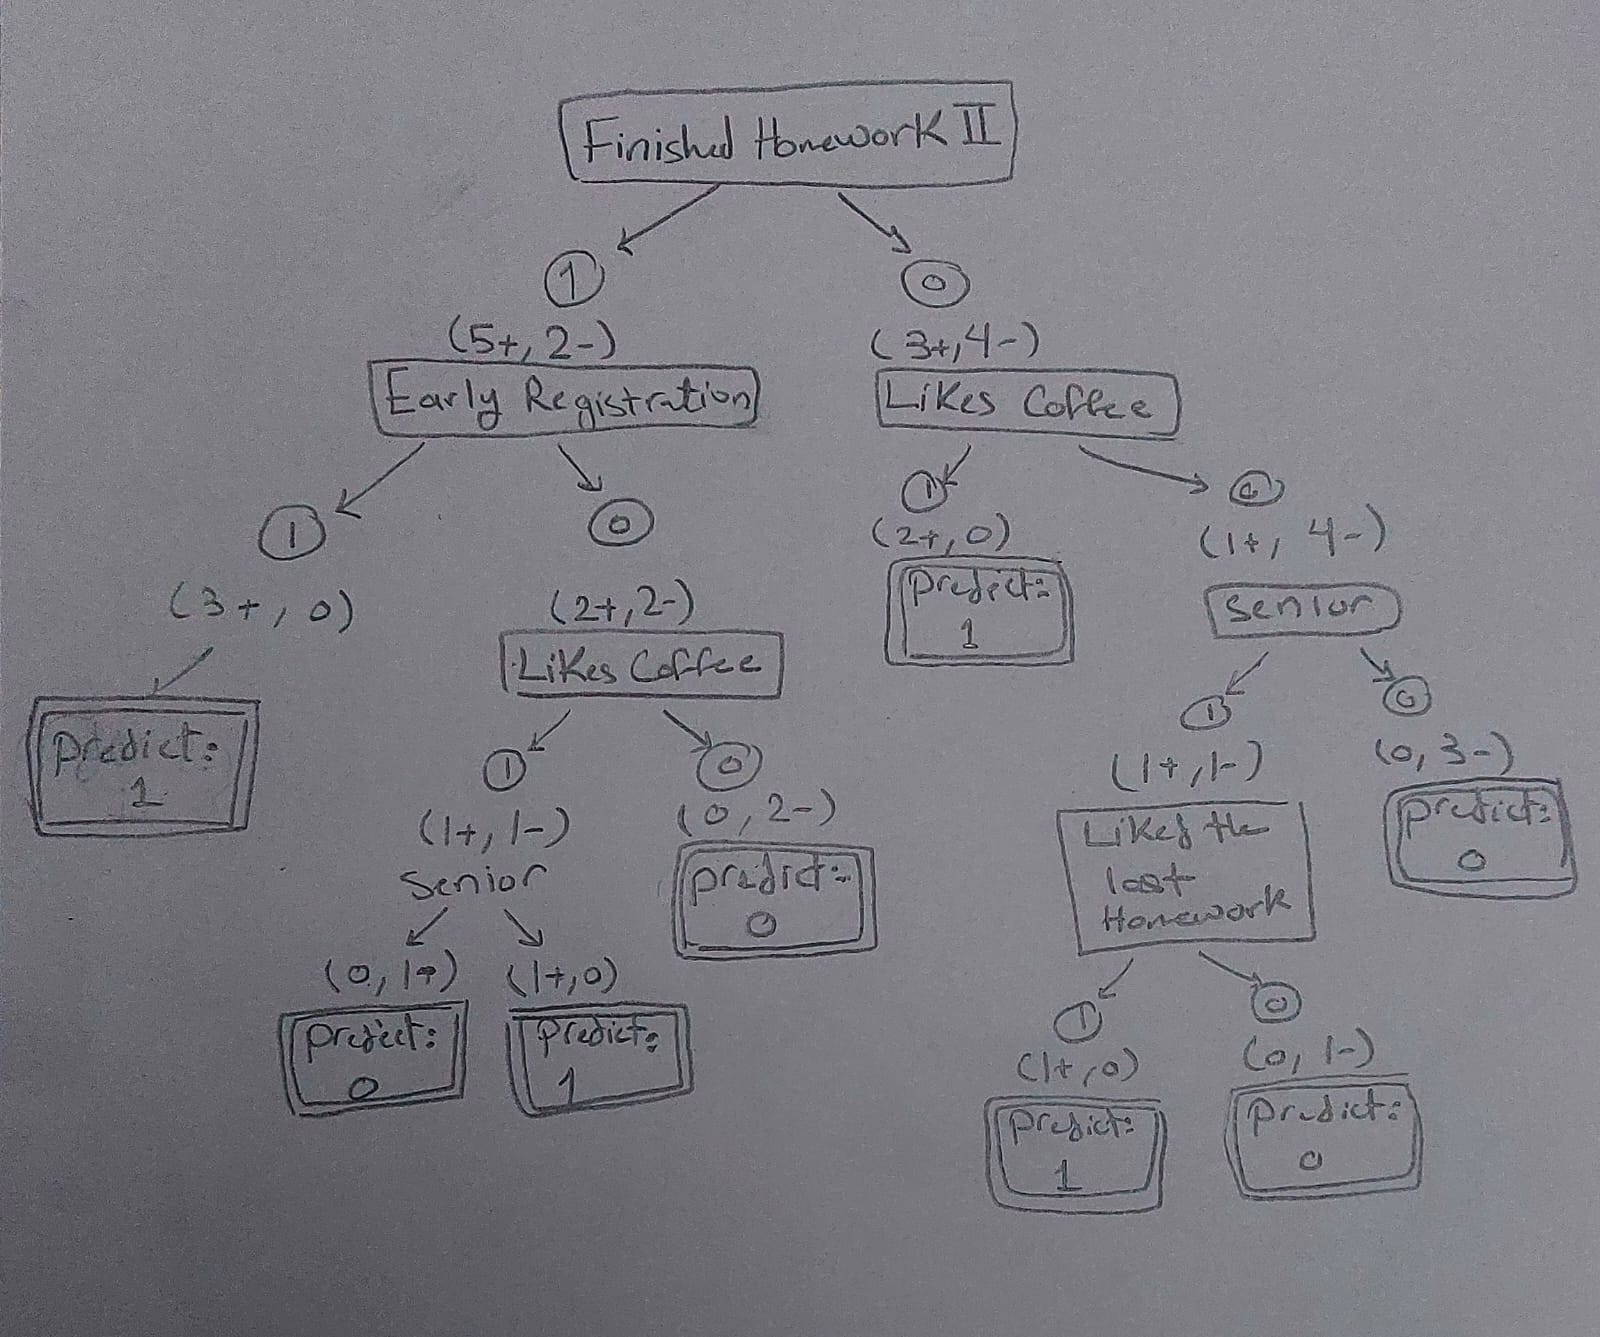


[click me for the detailled steps](https://drive.google.com/file/d/1TgW_GC9kL6hUU4LOs5xRj1IM0WCcXX6t/view?usp=sharing)

In [ ]:
early_registraion = np.array([1,1,0,0,0,0,1,0,0,1,1,0,0,1])
finished_homework= np.array([1,1,0,1,1,0,0,1,0,0,1,1,0,0])
senior = np.array([0,1,1,1,1,1,0,0,1,0,1,1,0,0])
likes_coffee = np.array([0,0,0,0,0,1,0,1,0,0,0,1,0,1])
liked_last_homework= np.array([1,1,0,1,0,1,1,1,1,0,0,1,1,0])
target = np.array([1,1,0,0,1,1,0,1,1,0,1,0,0,1])


df = pd.DataFrame({
    'early_registration': early_registraion,
    'finished_homework': finished_homework,
    'senior': senior,
    'likes_coffee': likes_coffee,
    'liked_last_homework': liked_last_homework,
    'target': target
})

# Select the features and target variable
slc = [0,1,2,3,4]
X_manual = df.values[:, slc]

y_manual= df.iloc[:,-1:].values.flatten()
# Split the data into train and test sets
X_manual_train, X_manual_test, y_manual_train, y_manual_test = train_test_split(X_manual, y_manual, test_size=0.25, random_state=10)









In [ ]:
MyModel2 = DecisionTree()
MyModel2.fit(X_manual_train, y_manual_train)

y_manual_pred = MyModel2.predict(X_manual_test)
acc2 = accuracy(y_manual_test, y_manual_pred)

print("Accuracy = %", acc2*100)

MyModel2.print_tree()


Accuracy = % 25.0
X0 <= 0
|   X3 <= 0
|   |   X4 <= 0
|   |   |   X1 <= 0
|   |   |   |   Predict: 0
|   |   |   |   Predict: 1
|   |   |   Predict: 1
|   |   X1 <= 0
|   |   |   Predict: 1
|   |   |   Predict: 0
|   X1 <= 0
|   |   X3 <= 0
|   |   |   Predict: 0
|   |   |   Predict: 1
|   |   Predict: 1


In [ ]:
# the data is too small
MyModel2_withoutSplit = DecisionTree()
MyModel2_withoutSplit.fit(X_manual, y_manual)

MyModel2_withoutSplit.print_tree()

X1 <= 0
|   X3 <= 0
|   |   X2 <= 0
|   |   |   Predict: 0
|   |   |   X4 <= 0
|   |   |   |   Predict: 0
|   |   |   |   Predict: 1
|   |   Predict: 1
|   X0 <= 0
|   |   X2 <= 0
|   |   |   Predict: 1
|   |   |   X4 <= 0
|   |   |   |   Predict: 1
|   |   |   |   Predict: 0
|   |   Predict: 1
